# Bagging, Random Forests and Boosting for Regression
### Predicting Diamond Prices with

### Data Set Information:

**A dataset containing the prices and other features of almost 54,000 diamonds.**

### Features description

**Number of Attributes: 10 (9 predictive features, 1 target)**

Feature Information: A data frame with 53,940 rows and 10 variables:

price: price in US dollars (\$326--\$18,823) **(target)**

carat: weight of the diamond (0.2--5.01)

cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color: diamond colour, from J (worst) to D (best)

clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x: length in mm (0--10.74)

y: width in mm (0--58.9)

z: depth in mm (0--31.8)

depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table: width of top of diamond relative to widest point (43--95)

In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

## Data Preparation

In [2]:
# importing data
data_path= './data/diamonds.csv'
diamonds = pd.read_csv(data_path)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Using dummy variable for categorical features

In [3]:
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)],axis=1)
diamonds.drop(['cut','color','clarity'], axis=1, inplace=True)

In [4]:
diamonds.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


### Train and test sets and scaling

In [5]:
target_name = 'price'
robust_scaler = RobustScaler()
X = diamonds.drop('price', axis=1)
feature_names = X.columns
X = robust_scaler.fit_transform(X)
y = diamonds[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

### Preparing a DataFrame for model analysis

In [6]:
models = pd.DataFrame(index=['train_rmse', 'test_rmse'], 
                      columns=['KNN', 'Bagging', 'RandomForest', 'Boosting'])

## A. K-Nearest Neighbors Model

In [8]:
# 2. Create an instance of the estimator
knn = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='euclidean', n_jobs=-1)
# 3. Use the trainning data to train the estimator
knn.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_rmse','KNN'] = mean_squared_error(y_pred=knn.predict(X_train), 
                                                    y_true=y_train, squared=False)

models.loc['test_rmse','KNN'] = mean_squared_error(y_pred=knn.predict(X_test), 
                                                   y_true=y_test, squared=False)

## B. Bagging

In [10]:
# 2. Create an instance of the estimator
# We can use any model we like as input to Bagging
knn_for_bagging = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='euclidean')
# n_estimators is how manly boostrap samples of dataset all fitted to the models created. 
# max_features <1 to select less than all features. Default=1
bagging = BaggingRegressor(base_estimator=knn_for_bagging, n_estimators=15, max_features=0.75, 
                            random_state=55, n_jobs=-1)
# 3. Use the trainning data to train the estimator
bagging.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_rmse','Bagging'] = mean_squared_error(y_pred=bagging.predict(X_train), 
                                                    y_true=y_train, squared=False)

models.loc['test_rmse','Bagging'] = mean_squared_error(y_pred=bagging.predict(X_test), 
                                                   y_true=y_test, squared=False)

## C. Random Forests

In [12]:
# 2. Create an instance of the estimator
# n_estimators is how many individual trees
# max_depth how deep the trees can be
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
# 3. Use the training data to train the estimator
RF.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_rmse','RandomForest'] = mean_squared_error(y_pred=RF.predict(X_train), 
                                                    y_true=y_train, squared=False)

models.loc['test_rmse','RandomForest'] = mean_squared_error(y_pred=RF.predict(X_test), 
                                                   y_true=y_test, squared=False)

## D. Boosting

In [13]:
# 2. Create an instance of the estimator
# n_estimators how many estimators created
# learning_rate shrink contribution of each regressor
boosting = AdaBoostRegressor(n_estimators=50, learning_rate=0.05, random_state=55)                             
# 3. Use the training data to train the estimator
boosting.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_rmse','Boosting'] = mean_squared_error(y_pred=boosting.predict(X_train), 
                                                    y_true=y_train, squared=False)

models.loc['test_rmse','Boosting'] = mean_squared_error(y_pred=boosting.predict(X_test), 
                                                   y_true=y_test, squared=False)

In [14]:
models

,KNN,Bagging,RandomForest,Boosting
train_rmse,7.03008,335.947,377.135,1349.21
test_rmse,806.987,829.489,613.119,1346.5


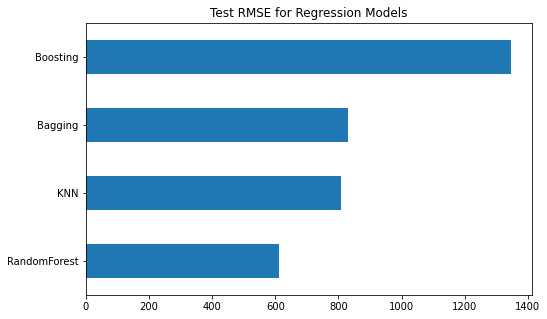

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
models.loc['test_rmse'].sort_values().plot(kind='barh', ax=ax)
ax.set_title('Test RMSE for Regression Models');

Boosting performed worst even though beeing the most komplex model. Best for Random forest

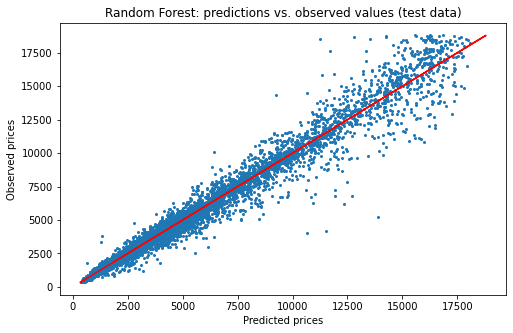

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(RF.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('Random Forest: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices');

## Using the best model to predict some diamond prices

In [17]:
n_pred=10
ind_pred = RF.predict(X_test[:n_pred,])
print('Real price, Predicted price:')
for i, pred in enumerate(ind_pred):
    print(round(y_test.values[i]), round(pred), sep=', ')

Real price, Predicted price:
1882, 1784
9586, 9592
5058, 4907
2780, 2666
2811, 2612
644, 660
1378, 1420
552, 572
7823, 7846
12800, 13046
